In [432]:
import numpy as np
import matplotlib.pyplot as plt
import rotunno as rt
import mpmath
import continuous_N_helpers as cn
import itertools

In [419]:
r1 = [None]*5
r2 = [None]*5
r3 = [None]*5

A = 1
m = 2
N_final = 3
H1 = 2
H2 = np.linspace(H1, H1+4, 1000)

In [420]:
for n in range(2,7):
        
    del_H = (H2-H1)/n
    del_N = (N_final-1)/n*np.ones(len(H2))

    H = [H1 + j*del_H for j in range(n)]
    N = [1 + j*del_N for j in range(n+1)]

    # n expressions for the Ak and Bk coefficients
    Ak = [None for i in range(n+1)]
    Bk = [None for i in range(n+1)]

    Ak[n] = A*np.ones(len(H2))
    Bk[n] = 0*np.ones(len(H2))

    Ak[n-1] = A*(N[n-1]+N[n])/(2*N[n-1])
    Bk[n-1] = A*(N[n-1]-N[n])/(2*N[n-1])

    for j in range(n-1, 0, -1):
        Ak[j-1] = (
            Ak[j]*(N[j]+N[j-1])/(2*N[j-1])*np.exp(-1j*m*N[j]*del_H)
            + Bk[j]*(N[j-1]-N[j])/(2*N[j-1])*np.exp(1j*m*N[j]*del_H))
        Bk[j-1] = (
            Ak[j]*(-N[j]+N[j-1])/(2*N[j-1])*np.exp(-1j*m*N[j]*del_H)
            + Bk[j]*(N[j-1]+N[j])/(2*N[j-1])*np.exp(1j*m*N[j]*del_H))

    # Incident
    A_inc = np.abs(Ak[0])

    # Reflected
    A_ref = np.abs(Bk[0])

    r1[n-2] = A_ref/A_inc
    r2[n-2] = A/A_inc

In [421]:
for n in range(2,7):
    
    del_H = (H2-H1)/n
    del_N = (N_final-1)/n*np.ones(len(H2))

    H = [H1 + j*del_H for j in range(0, n+1)]
    N = [1 + j*del_N for j in range(n+1)]

    # n expressions for the Ak and Bk coefficients
    Ak = [None for i in range(n+1)]
    Bk = [None for i in range(n+1)]
    
    Ak[0] = A/(2*1j)*np.ones(len(H2))
    Bk[0] = -A/(2*1j)*np.ones(len(H2))
    
    Ak[1] = A/(2*1j*N[1])*(np.cos(m*H[0])+1j*N[1]*np.sin(m*H[0]))
    Bk[1] = -A/(2*1j*N[1])*(np.cos(m*H[0])-1j*N[1]*np.sin(m*H[0]))
        
    for j in range(2, n+1):
        Ak[j] = (
            Ak[j-1]*(N[j]+N[j-1])/(2*N[j])*np.exp(1j*m*N[j-1]*del_H)
            + Bk[j-1]*(N[j]-N[j-1])/(2*N[j])*np.exp(-1j*m*N[j-1]*del_H))
        Bk[j] = (
            Ak[j-1]*(N[j]-N[j-1])/(2*N[j])*np.exp(1j*m*N[j-1]*del_H)
            + Bk[j-1]*(N[j]+N[j-1])/(2*N[j])*np.exp(-1j*m*N[j-1]*del_H))

    r3[n-2] = np.abs(Ak[0]/Ak[-1])

In [412]:
besselj = np.frompyfunc(mpmath.besselj, 2, 1)
pcfd = np.frompyfunc(mpmath.pcfd, 2, 1)

In [413]:
def gen_theta_A_D(A0=1, f_min=0, f_max=6):

    del_f = (f_max-f_min)/1000
    f = np.arange(f_min, f_max+del_f, del_f)

    re = (
        besselj(-1/4, f**2/2)*np.cos(f**2/2)
        - besselj(1/4, f**2/2)*np.cos(f**2/2+np.pi/4))
    im = (
        besselj(-1/4, f**2/2)*np.sin(f**2/2)
        - besselj(1/4, f**2/2)*np.sin(f**2/2+np.pi/4))
    re = np.array(re).astype(float)
    im = np.array(im).astype(float)
    theta = np.arctan(im/re)
    A = np.sqrt(np.pi*f/2)*np.sqrt(re**2+im**2).astype(float)

    Da = np.array(pcfd(-1/2, (1+1j)*f)).astype(complex)
    Db = np.array(pcfd(-1/2, (1-1j)*f)).astype(complex)
    return theta, A, Da, Db, f

In [414]:
def calc_refl_coefficients(H1, H2, k, N, A0=1):
    
    m = k/A0
    
    G = (N-1)/(H2-H1)

    theta_1, A_1 = cn.calc_theta_A(H1, k, N, H1, G, A0)
    dA_1 = cn.calc_dA(H1, k, N, H1, G, A0)
    alpha_1 = cn.calc_alpha(H1, k, N, H1, G, A0)
    
    theta_2, A_2 = cn.calc_theta_A(H2, k, N, H1, G, A0)
    dA_2 = cn.calc_dA(H2, k, N, H1, G, A0)
    alpha_2 = cn.calc_alpha(H2, k, N, H1, G, A0)
    
    f_1 = cn.calc_f(H1, k, N, H1, G, A0)
    f_2 = cn.calc_f(H2, k, N, H1, G, A0)
    
    Da_1 = np.array(pcfd(-1/2, (1+1j)*f_1)).astype(complex)
    Da_2 = np.array(pcfd(-1/2, (1+1j)*f_2)).astype(complex)
    Db_1 = np.array(pcfd(-1/2, (1-1j)*f_1)).astype(complex)
    Db_2 = np.array(pcfd(-1/2, (1-1j)*f_2)).astype(complex)
    
    gamma = (m*np.cos(m*H1)+np.sin(m*H1)*(-dA_1/A_1+alpha_1))/(2*alpha_1)

    beta_p = (1j*m*N+alpha_2-dA_2/A_2)/(2*alpha_2)

    X_p = 1/2*((1-beta_p)*(Da_1/Da_2)+beta_p*(Db_1/Db_2))
    Y_p = 1j/(2*m)*(
        (1-beta_p)*(Da_1/Da_2)*(-alpha_1+dA_1/A_1)
        + beta_p*(Db_1/Db_2)*(alpha_1+dA_1/A_1))

    mu_p = gamma*(1-beta_p)*Db_2*Da_1-(np.sin(m*H1)-gamma)*beta_p*Da_2*Db_1

    T = 1/2*((np.sin(m*H1)-gamma)*(Da_2/Da_1)+gamma*(Db_2/Db_1))
    S = 1/(2*1j*m*N)*(
        (np.sin(m*H1)-gamma)*(Da_2/Da_1)*(-alpha_2+dA_2/A_2)
        + gamma*(Db_2/Db_1)*(alpha_2+dA_2/A_2))
        
    return abs((X_p+Y_p)/(X_p-Y_p)), abs(1/(X_p-Y_p)), abs(1/(2*1j*(S+T)))

In [415]:
def gen_coefficients(N, m, H1, H2):
    
#     lambda_z = 2*np.pi*np.array([1/8, 1/4, 1/2, 1, 2, 4, 8])
#     m=2*np.pi/lambda_z
    A0 = 1
    r1 = np.zeros(len(H2), dtype=float)
    r2 = np.zeros(len(H2), dtype=float)
    r3 = np.zeros(len(H2), dtype=float)
    for i in range(1, len(H2)):
        [r1[i], r2[i], r3[i]] = calc_refl_coefficients(
            H1, H2[i], m, N)
    r1[0] = np.abs((1-N)/(N+1))
    r2[0] = np.abs(2/(N+1))
    r3[0] = N/np.sqrt(np.cos(m*H1)**2+N**2*np.sin(m*H1)**2)
    return r1, r2, r3

In [416]:
r1_ex, r2_ex, r3_ex = gen_coefficients(N_final, m, H2[0], H2)

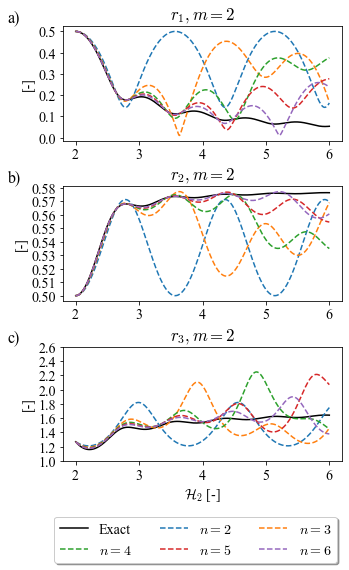

In [434]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.close('all')
fig, axes = plt.subplots(3, 1, figsize=(5, 8))

rt.init_fonts()
plt.rcParams.update({'font.size': 14})

labels = [r'$n=' + r'{}$'.format(i+2) for i in range(len(r1))]

axes[0].plot(H2, r1_ex, 'k', label='Exact')
[axes[0].plot(H2, r1[i], '--', label=labels[i]) for i in range(len(r1))]
axes[1].plot(H2, r2_ex, 'k', label='Exact')
[axes[1].plot(H2, r2[i], '--', label=labels[i]) for i in range(len(r2))]
axes[2].plot(H2, r3_ex, 'k', label='Exact')
[axes[2].plot(H2, r3[i], '--', label=labels[i]) for i in range(len(r3))]

plt.sca(axes[0])
# plt.xticks(np.arange(H1, H2_max+1))
start, end, step = rt.nice_bounds(0, .5, 5)
plt.yticks(np.arange(start, end+step, step))
title = r'$r_1, m=2$'
plt.title(title)
plt.ylabel('[-]')
# plt.xlabel('$\mathcal{H}_2$ [-]')

plt.sca(axes[1])
# plt.xticks(np.arange(H1, H2_max+1))
start, end, step = rt.nice_bounds(.5, .58, 10)
plt.yticks(np.arange(start, end+step, step))
title = r'$r_2, m=2$'
plt.title(title)
plt.ylabel('[-]')
# plt.xlabel('$\mathcal{H}_2$ [-]')

plt.sca(axes[2])
# plt.xticks(np.arange(H1, H2_max+1))
start, end, step = rt.nice_bounds(1, 2.6, 10)
plt.yticks(np.arange(start, end+step, step))
title = r'$r_3, m=2$'
plt.title(title)
plt.ylabel('[-]')
plt.xlabel('$\mathcal{H}_2$ [-]')

plt.subplots_adjust(hspace=0.4)

rt.make_subplot_labels(axes.flatten(), x_shift=-.2, y_shift=1.04)

lines, labels = axes[2].get_legend_handles_labels()

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

axes[2].legend(
    flip(lines, 3), flip(labels, 3), 
    loc='lower center', bbox_to_anchor=(.475, -.95),
    ncol=3, fancybox=True, shadow=True)

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/phd/theory_paper/coefficients_approx.png', 
    dpi=200, bbox_inches='tight', facecolor='white')